In [1]:
import networkx as nx
import itertools
import pandas as pd
import numpy as np
from stellargraph import StellarGraph
from rdkit.Chem import AllChem, DataStructs
import json
from sklearn import preprocessing, feature_extraction, model_selection
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow import keras
import tensorflow as tf

import stellargraph as sg
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import HinSAGELinkGenerator
from stellargraph.layer import HinSAGE, link_classification
from tensorflow.keras import Model, optimizers, losses, metrics

import multiprocessing
from stellargraph import datasets
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('float32')

2023-06-27 17:24:14.067790: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-27 17:24:17.591316: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
g = nx.read_graphml("./graph/lotus_DB_as_graph.gml")
#species_features_dummy = pd.read_csv("./data/species_features_dummy.csv.gz", index_col=0)
#species_features_dummy = pd.read_csv("./data/species_BaseNEncoder.csv.gz", index_col=0)
species_features_dummy = pd.read_csv("./data/species_Multi_dim_scale.csv.gz", index_col=0)
molecule_features_dummy = pd.read_csv("./data/mol_dummy_rdkit.csv.gz", index_col=0).astype("int8")
df_agg = pd.read_csv("./data/lotus_aggregated.csv", index_col=0)
#molecule_features_dummy = pd.read_csv("./data/molecule_features_dummy.csv.gz", index_col=0).astype('int8')

In [6]:
G = StellarGraph.from_networkx(g,
                               node_features={'species':species_features_dummy,
                                              'molecule': molecule_features_dummy})
print(G.info())
G.check_graph_for_ml()

StellarDiGraph: Directed multigraph
 Nodes: 184990, Edges: 876144

 Node types:
  molecule: [148190]
    Features: float32 vector, length 1024
    Edge types: molecule-present_in->species
  species: [36800]
    Features: float32 vector, length 10
    Edge types: species-has->molecule

 Edge types:
    species-has->molecule: [438072]
        Weights: all 1 (default)
        Features: none
    molecule-present_in->species: [438072]
        Weights: all 1 (default)
        Features: none


In [7]:
batch_size = 256 #default: 200
epochs = 30 #default: 20
num_samples = [1, 1]
num_workers = multiprocessing.cpu_count()-2

In [8]:
# Define an edge splitter on the original graph G:
edge_splitter_test = EdgeSplitter(G)

# Randomly sample a fraction p=0.3 of all positive links, and same number of negative links, from G, and obtain the
# reduced graph G_test with the sampled links removed:
G_test, edge_ids_test, edge_labels_test = edge_splitter_test.train_test_split(
    p=0.1, method="global", keep_connected=False, edge_label="present_in"
)

Network has 438072 edges of type present_in
Network has 438072 edges of type present_in
** Sampled 43807 positive and 43807 negative edges. **


In [9]:
# Define an edge splitter on the reduced graph G_test:
edge_splitter_train = EdgeSplitter(G_test)

# Randomly sample a fraction p=0.3 of all positive links, and same number of negative links, from G_test, and obtain the
# reduced graph G_train with the sampled links removed:
G_train, edge_ids_train, edge_labels_train = edge_splitter_train.train_test_split(
    p=0.1, method="global", keep_connected=False, edge_label="present_in"
)

Network has 394265 edges of type present_in
Network has 394265 edges of type present_in
** Sampled 39426 positive and 39426 negative edges. **


In [10]:
print(G_train.info())

StellarDiGraph: Directed multigraph
 Nodes: 184990, Edges: 792911

 Node types:
  molecule: [148190]
    Features: float32 vector, length 1024
    Edge types: molecule-present_in->species
  species: [36800]
    Features: float32 vector, length 10
    Edge types: species-has->molecule

 Edge types:
    species-has->molecule: [438072]
        Weights: all 1 (default)
        Features: none
    molecule-present_in->species: [354839]
        Weights: all 1 (default)
        Features: none


In [11]:
print(G_test.info())

StellarDiGraph: Directed multigraph
 Nodes: 184990, Edges: 832337

 Node types:
  molecule: [148190]
    Features: float32 vector, length 1024
    Edge types: molecule-present_in->species
  species: [36800]
    Features: float32 vector, length 10
    Edge types: species-has->molecule

 Edge types:
    species-has->molecule: [438072]
        Weights: all 1 (default)
        Features: none
    molecule-present_in->species: [394265]
        Weights: all 1 (default)
        Features: none


In [12]:
train_gen = HinSAGELinkGenerator(G_train,
                                 batch_size=batch_size,
                                 num_samples=num_samples,
                                 head_node_types=["molecule", "species"])
train_flow = train_gen.flow(edge_ids_train, edge_labels_train, shuffle=True)

In [13]:
test_gen = HinSAGELinkGenerator(G_test,
                                batch_size=batch_size,
                                num_samples=num_samples,
                                head_node_types=["molecule", "species"])
test_flow = test_gen.flow(edge_ids_test, edge_labels_test)

In [14]:
hinsage_layer_sizes = [128, 128]
hinsage = HinSAGE(layer_sizes=hinsage_layer_sizes,
                  generator=train_gen,
                  bias=True,
                  dropout=0.3,
                 activations=['elu','selu'])

In [15]:
# Build the model and expose input and output sockets of graphsage model
# for link prediction
x_inp, x_out = hinsage.in_out_tensors()

/usr/local/Caskroom/mambaforge/base/envs/stellar_graph/lib/python3.10/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [16]:
prediction = link_classification(output_dim=1,
                                 output_act="sigmoid",
                                 edge_embedding_method="l1")(x_out)

link_classification: using 'l1' method to combine node embeddings into edge embeddings


In [17]:
model = keras.Model(inputs=x_inp, outputs=prediction)
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-1,
    decay_steps=10000,
    decay_rate=0.95)

optimizer=keras.optimizers.Adam(learning_rate=lr_schedule)
#optimizer = mixed_precision.LossScaleOptimizer(optimizer)

model.compile(
    optimizer=optimizer,
    loss=keras.losses.binary_crossentropy,
    metrics=["AUC"],
)

In [18]:
init_train_metrics = model.evaluate(train_flow, workers=num_workers, verbose=2)
init_test_metrics = model.evaluate(test_flow, workers=num_workers, verbose=2)

print("\nTrain Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

309/309 - 6s - loss: 0.6983 - auc: 0.4830 - 6s/epoch - 20ms/step
343/343 - 6s - loss: 0.6990 - auc: 0.4759 - 6s/epoch - 16ms/step

Train Set Metrics of the initial (untrained) model:
	loss: 0.6983
	auc: 0.4830

Test Set Metrics of the initial (untrained) model:
	loss: 0.6990
	auc: 0.4759


In [19]:
callbacks = keras.callbacks.EarlyStopping(monitor="val_loss",
                                          patience=10,
                                          mode="auto",
                                          restore_best_weights=True)

history = model.fit(train_flow,
                    epochs=epochs,
                    workers=num_workers,
                    validation_data=test_flow,
                    verbose=2,
                    callbacks=[callbacks],
                    validation_split=0.0,
                    shuffle=True
                   )

Epoch 1/30
309/309 - 20s - loss: 0.5817 - auc: 0.7572 - val_loss: 0.5051 - val_auc: 0.8551 - 20s/epoch - 63ms/step
Epoch 2/30
309/309 - 12s - loss: 0.5101 - auc: 0.8272 - val_loss: 0.4359 - val_auc: 0.8794 - 12s/epoch - 40ms/step
Epoch 3/30
309/309 - 20s - loss: 0.4772 - auc: 0.8517 - val_loss: 0.4178 - val_auc: 0.8899 - 20s/epoch - 65ms/step
Epoch 4/30
309/309 - 18s - loss: 0.4562 - auc: 0.8659 - val_loss: 0.4061 - val_auc: 0.8967 - 18s/epoch - 59ms/step
Epoch 5/30
309/309 - 18s - loss: 0.4423 - auc: 0.8750 - val_loss: 0.3917 - val_auc: 0.9044 - 18s/epoch - 60ms/step
Epoch 6/30
309/309 - 12s - loss: 0.4331 - auc: 0.8808 - val_loss: 0.3890 - val_auc: 0.9059 - 12s/epoch - 40ms/step
Epoch 7/30
309/309 - 17s - loss: 0.4257 - auc: 0.8851 - val_loss: 0.3775 - val_auc: 0.9109 - 17s/epoch - 56ms/step
Epoch 8/30
309/309 - 18s - loss: 0.4171 - auc: 0.8901 - val_loss: 0.3716 - val_auc: 0.9139 - 18s/epoch - 58ms/step
Epoch 9/30
309/309 - 19s - loss: 0.4130 - auc: 0.8924 - val_loss: 0.4260 - val_a

2023-06-27 17:38:00.385634: W tensorflow/core/framework/op_kernel.cc:1818] INVALID_ARGUMENT: TypeError: 'NoneType' object is not subscriptable
Traceback (most recent call last):

  File "/usr/local/Caskroom/mambaforge/base/envs/stellar_graph/lib/python3.10/site-packages/tensorflow/python/ops/script_ops.py", line 271, in __call__
    ret = func(*args)

  File "/usr/local/Caskroom/mambaforge/base/envs/stellar_graph/lib/python3.10/site-packages/tensorflow/python/autograph/impl/api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "/usr/local/Caskroom/mambaforge/base/envs/stellar_graph/lib/python3.10/site-packages/tensorflow/python/data/ops/dataset_ops.py", line 1039, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/usr/local/Caskroom/mambaforge/base/envs/stellar_graph/lib/python3.10/site-packages/keras/engine/data_adapter.py", line 901, in wrapped_generator
    for data in generator_fn():

  File "/usr/local/Caskroom/mambaforge/b

309/309 - 19s - loss: 0.3570 - auc: 0.9209 - val_loss: 0.3382 - val_auc: 0.9300 - 19s/epoch - 63ms/step
Epoch 29/30
309/309 - 13s - loss: 0.3538 - auc: 0.9224 - val_loss: 0.3437 - val_auc: 0.9312 - 13s/epoch - 41ms/step
Epoch 30/30


2023-06-27 17:38:32.584915: W tensorflow/core/framework/op_kernel.cc:1818] INVALID_ARGUMENT: TypeError: 'NoneType' object is not subscriptable
Traceback (most recent call last):

  File "/usr/local/Caskroom/mambaforge/base/envs/stellar_graph/lib/python3.10/site-packages/tensorflow/python/ops/script_ops.py", line 271, in __call__
    ret = func(*args)

  File "/usr/local/Caskroom/mambaforge/base/envs/stellar_graph/lib/python3.10/site-packages/tensorflow/python/autograph/impl/api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "/usr/local/Caskroom/mambaforge/base/envs/stellar_graph/lib/python3.10/site-packages/tensorflow/python/data/ops/dataset_ops.py", line 1039, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/usr/local/Caskroom/mambaforge/base/envs/stellar_graph/lib/python3.10/site-packages/keras/engine/data_adapter.py", line 901, in wrapped_generator
    for data in generator_fn():

  File "/usr/local/Caskroom/mambaforge/b

309/309 - 17s - loss: 0.3526 - auc: 0.9230 - val_loss: 0.3357 - val_auc: 0.9312 - 17s/epoch - 56ms/step


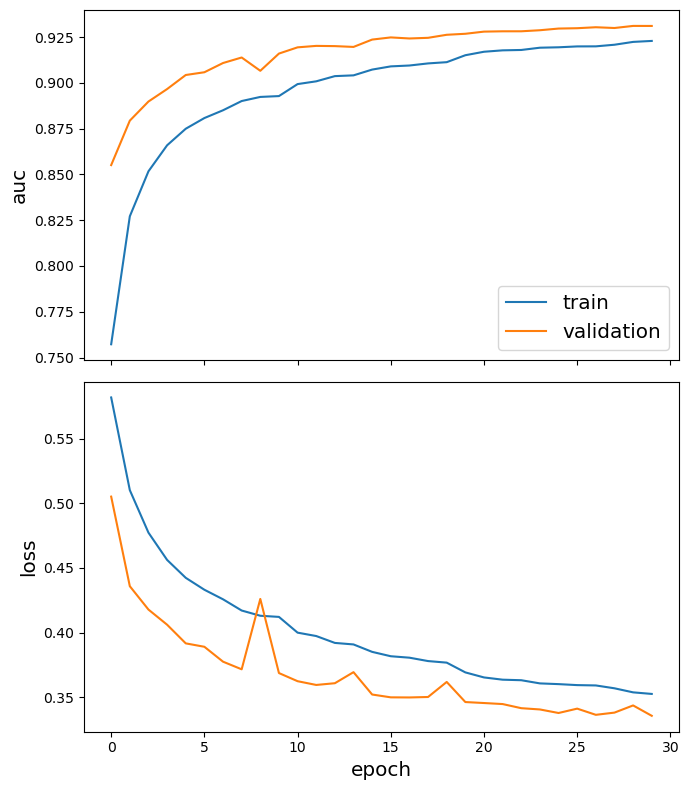

In [20]:
sg.utils.plot_history(history)

In [21]:
train_metrics = model.evaluate(train_flow, verbose=2)
test_metrics = model.evaluate(test_flow, verbose=2)

print("\nTrain Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

309/309 - 5s - loss: 0.2668 - auc: 0.9571 - 5s/epoch - 16ms/step
343/343 - 5s - loss: 0.3341 - auc: 0.9319 - 5s/epoch - 15ms/step

Train Set Metrics of the trained model:
	loss: 0.2668
	auc: 0.9571

Test Set Metrics of the trained model:
	loss: 0.3341
	auc: 0.9319


In [22]:
test_pred = HinSAGELinkGenerator(G,
                                 batch_size=128,
                                num_samples=num_samples,
                                head_node_types=["molecule", "species"]).flow(edge_ids_test, edge_labels_test)

In [23]:
predictions = model.predict(test_pred, workers=3)

685/685 [==============================] - 7s 9ms/step


In [24]:
predictions = predictions.flatten()

In [25]:
test = predictions[(predictions>0.9) | (predictions<0.1)]
test = test>0.5

In [26]:
test = test.astype('int8')

(array([27538.,  8089.,  5285.,  4047.,  3736.,  3515.,  3873.,  4402.,
         6331., 20798.]),
 array([5.58189895e-05, 1.00039124e-01, 2.00022429e-01, 3.00005734e-01,
        3.99989039e-01, 4.99972343e-01, 5.99955678e-01, 6.99938953e-01,
        7.99922287e-01, 8.99905562e-01, 9.99888897e-01]),
 <BarContainer object of 10 artists>)

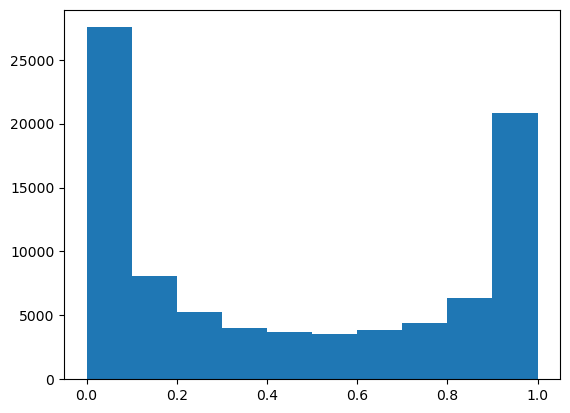

In [27]:
plt.hist(predictions)

In [28]:
np.where((predictions>0.9) | (predictions<0.1))

(array([    6,     9,    10, ..., 87609, 87611, 87613]),)

In [29]:
sum(test == edge_labels_test[np.where((predictions>0.9) | (predictions<0.1))])/len(test)

0.9412507242777916

In [30]:
len(test)/len(predictions)

0.5515556874472116

In [31]:
df_agg = pd.read_csv("./data/lotus_aggregated.csv", index_col=0)

In [32]:
finaly_test = np.array(list(zip(df_agg.structure_smiles_2D[:1000],df_agg.organism_name[::-1][:1000])))

In [33]:
final_test = HinSAGELinkGenerator(G,
                                batch_size=128,
                                num_samples=num_samples,
                                head_node_types=["molecule", "species"]).flow(finaly_test, np.ones(len(finaly_test)).reshape(-1, 1))

In [34]:
res = model.predict(final_test).flatten()

8/8 [==============================] - 0s 9ms/step


In [35]:
res[res>0.9]

array([0.9790229 , 0.9981784 , 0.9574181 , 0.96575314, 0.9831523 ,
       0.9199743 , 0.99285644, 0.916918  , 0.9286133 , 0.9341604 ,
       0.934744  , 0.9968909 , 0.9210354 , 0.91861516, 0.9959626 ,
       0.9662845 , 0.9928529 , 0.92395157, 0.98002064, 0.98952794,
       0.99904156, 0.9003068 , 0.9753665 , 0.9915076 , 0.9118756 ,
       0.98723453, 0.99583966, 0.91267323, 0.9385543 , 0.9906539 ,
       0.9516693 , 0.95016974, 0.9743162 , 0.9287255 , 0.98175466,
       0.9961362 , 0.9940377 , 0.99959904, 0.9571324 , 0.9469965 ,
       0.9739665 , 0.99769735, 0.9607878 , 0.98786587, 0.9983597 ,
       0.993761  , 0.97169775, 0.9663501 , 0.9331021 , 0.98793966,
       0.9786901 , 0.98566365, 0.96200377, 0.98938304, 0.9992895 ,
       0.99213994, 0.9906879 , 0.98786926, 0.9036397 , 0.9771786 ,
       0.9798532 , 0.99257547, 0.9175026 , 0.9970839 , 0.9795668 ,
       0.9159113 , 0.96568114, 0.99515235, 0.99814796, 0.9750453 ,
       0.9883338 , 0.92522657, 0.9765    , 0.998901  , 0.98563

In [36]:
len(res[res>0.9])/len(res)

0.201

In [37]:
finaly_test[res>0.9]

array([['CCC(CCC(C)C1CCC2C3CC=C4CC(O)CCC4(C)C3CCC12C)C(C)C',
        'Melicope xanthoxyloides'],
       ['O=C(O)c1ccc(O)c(O)c1', 'Luisia brachystachys'],
       ['CCCCCCO', 'Symphoricarpos albus'],
       ['O=c1cc(-c2ccc(O)cc2)oc2cc(OC3OC(CO)C(O)C(O)C3O)cc(O)c12',
        'Iris leptophylla'],
       ['COc1ccc(-c2cc(=O)c3c(O)c(OC)c(OC)cc3o2)cc1',
        'Illicium dunnianum'],
       ['C=C(C)C1CCC2=CCCC(C)C2(C)C1', 'Salvia deserti'],
       ['CC1=CCC(C(C)C)=CC1', 'Krameria erecta'],
       ['CCCCCC=CCC=CCC=CCCCCC(=O)O', 'Talaromyces wortmannii'],
       ['OCc1ccco1', 'Tilia tomentosa'],
       ['CC1OC(OCC2OC(Oc3cc4c(O)cc(O)cc4[o+]c3-c3ccc(O)c([O-])c3)C(O)C(O)C2O)C(O)C(O)C1O',
        'Brosimum acutifolium'],
       ['CC1=CC2C(C(C)C)CCC(C)C2(O)CC1', 'Citrus reticulata'],
       ['COc1c(-c2ccc(O)c(O)c2)oc2cc(O)cc(O)c2c1=O',
        'Beilschmiedia miersii'],
       ['CC(=O)c1ccc2c(c1)C=CC(C)(C)O2', 'Bonnetia paniculata'],
       ['C=C(C)C1CC=C(C)C(=O)C1', 'Trypanosoma brucei'],
       ['CO

(array([297., 120.,  67.,  55.,  40.,  45.,  41.,  55.,  78., 202.]),
 array([2.54733051e-04, 1.00189164e-01, 2.00123593e-01, 3.00058037e-01,
        3.99992466e-01, 4.99926895e-01, 5.99861324e-01, 6.99795723e-01,
        7.99730182e-01, 8.99664581e-01, 9.99599040e-01]),
 <BarContainer object of 10 artists>)

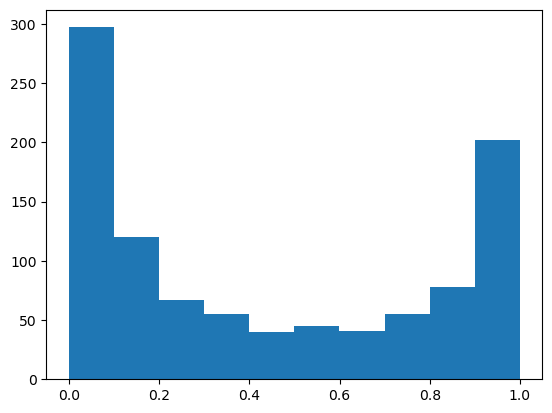

In [38]:
plt.hist(res)

In [39]:
org = df_agg.organism_name.unique()[:100]

In [40]:
mol = df_agg.structure_smiles_2D.unique()[:1000]

In [41]:
len(df_agg.structure_smiles_2D.unique())

28474

In [42]:
len(df_agg.organism_name.unique())

18413

In [43]:
%%time
combinations = list(itertools.product(mol, org))

CPU times: user 9.3 ms, sys: 1.85 ms, total: 11.1 ms
Wall time: 12 ms


In [44]:
%%time
A1, A2 = np.meshgrid(mol, org)

CPU times: user 570 µs, sys: 214 µs, total: 784 µs
Wall time: 773 µs


In [45]:
df_combinations = pd.DataFrame(combinations, columns=['structure_smiles_2D', 'organism_name'])

In [46]:
edge_test_final = df_combinations.to_numpy()

In [47]:
%%time
final_final_test = HinSAGELinkGenerator(G,
                                batch_size=256,
                                num_samples=num_samples,
                                head_node_types=["molecule", "species"]).flow(edge_test_final, np.ones(len(edge_test_final)).reshape(-1, 1))

CPU times: user 30.4 s, sys: 225 ms, total: 30.7 s
Wall time: 30.6 s


In [48]:
final_final_pred = model.predict(final_final_test).flatten()

391/391 [==============================] - 6s 15ms/step


In [49]:
len(final_final_pred)

100000

In [50]:
len(final_final_pred[final_final_pred>0.9])

15483

In [51]:
results = edge_test_final[final_final_pred>0.9]

In [52]:
results[10000:10100]

array([['C=C1C2CCC(C2)C1(C)C', 'Salvia wiedemannii'],
       ['C=C1C2CCC(C2)C1(C)C', 'Kalanchoe miniata'],
       ['C=C1C2CCC(C2)C1(C)C', 'Cyphanthera tasmanica'],
       ['C=C1C2CCC(C2)C1(C)C', 'Marrubium parviflorum'],
       ['C=C1C2CCC(C2)C1(C)C', 'Melanthera prostrata'],
       ['C=C1C2CCC(C2)C1(C)C', 'Prunus domestica'],
       ['C=C1C2CCC(C2)C1(C)C', 'Streptomyces'],
       ['C=C1C2CCC(C2)C1(C)C', 'Zanthoxylum chalybeum'],
       ['C=C1C2CCC(C2)C1(C)C', 'Erythrina addisoniae'],
       ['C=C1C2CCC(C2)C1(C)C', 'Artemisia valentina'],
       ['C=C1C2CCC(C2)C1(C)C', 'Codonopsis pilosula'],
       ['C=C1C2CCC(C2)C1(C)C', 'Brotherella henonii'],
       ['C=C1C2CCC(C2)C1(C)C', 'Zingiber ottensii'],
       ['C=C1C2CCC(C2)C1(C)C', 'Stilbella fimetaria'],
       ['C=C1C2CCC(C2)C1(C)C', 'Baptisia calycosa'],
       ['C=C1C2CCC(C2)C1(C)C', 'Sesamum radiatum'],
       ['C=C1C2CCC(C2)C1(C)C', 'Marchantia polymorpha'],
       ['C=C1C2CCC(C2)C1(C)C', 'Cryptomeria japonica'],
       ['C=C1C2CCC(

In [53]:
df_agg

,organism_name,structure_smiles_2D,reference_wikidata,organism_taxonomy_08genus,organism_taxonomy_06family,organism_taxonomy_05order,organism_taxonomy_04class,organism_taxonomy_03phylum,organism_taxonomy_02kingdom,organism_taxonomy_01domain,structure_taxonomy_classyfire_01kingdom,structure_taxonomy_classyfire_02superclass,structure_taxonomy_classyfire_03class,structure_taxonomy_classyfire_04directparent,total_papers_molecule,total_papers_species
0,Heracleum persicum,CCCCOC(=O)CCC,1,Heracleum,Apiaceae,Apiales,Magnoliopsida,Streptophyta,Archaeplastida,Eukaryota,Organic compounds,Lipids and lipid-like molecules,Fatty Acyls,Fatty acid esters,19,49
1,Euphorbia supina,CCC(CCC(C)C1CCC2C3CC=C4CC(O)CCC4(C)C3CCC12C)C(C)C,3,Euphorbia,Euphorbiaceae,Malpighiales,Magnoliopsida,Streptophyta,Archaeplastida,Eukaryota,Organic compounds,Lipids and lipid-like molecules,Steroids and steroid derivatives,Stigmastanes and derivatives,4986,125
2,Medicago sativa,O=C(O)c1ccc(O)c(O)c1,1,Medicago,Fabaceae,Fabales,Magnoliopsida,Streptophyta,Archaeplastida,Eukaryota,Organic compounds,Benzenoids,Benzene and substituted derivatives,Hydroxybenzoic acid derivatives,695,558
3,Guatteria blepharophylla,C=C1CCC2C(C3C(C)CCC13)C2(C)C,1,Guatteria,Annonaceae,Magnoliales,Magnoliopsida,Streptophyta,Archaeplastida,Eukaryota,Organic compounds,Lipids and lipid-like molecules,Prenol lipids,"5,10-cycloaromadendrane sesquiterpenoids",480,88
4,Stranvaesia davidiana var. davidiana,COc1cc(C(C)=O)ccc1O,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Organic compounds,Organic oxygen compounds,Organooxygen compounds,Alkyl-phenylketones,68,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,Baccharis vaccinioides,COc1ccc(C2CC(=O)c3c(O)cc(O)cc3O2)cc1,1,Baccharis,Asteraceae,Asterales,Magnoliopsida,Streptophyta,Archaeplastida,Eukaryota,Organic compounds,Phenylpropanoids and polyketides,Flavonoids,4'-O-methylated flavonoids,73,20
49996,Betula platyphylla var. japonica,CC(C)=CCCC(C)(O)C1CCC2(C)C1CCC1C3(C)CCC(OC(=O)...,1,Betula,Betulaceae,Fagales,Magnoliopsida,Streptophyta,Archaeplastida,Eukaryota,Organic compounds,Lipids and lipid-like molecules,Prenol lipids,Triterpenoids,4,71
49997,Luisia brachystachys,COc1cc(O)c2c(c1)CCc1cc(O)ccc1-2,1,Luisia,Orchidaceae,Asparagales,Magnoliopsida,Streptophyta,Archaeplastida,Eukaryota,Organic compounds,Benzenoids,Phenanthrenes and derivatives,Hydrophenanthrenes,19,5
49998,Melicope xanthoxyloides,COc1cc2c(OC)c3ccoc3nc2cc1OCC(O)C(C)(C)O,4,Melicope,Rutaceae,Sapindales,Magnoliopsida,Streptophyta,Archaeplastida,Eukaryota,Organic compounds,Organoheterocyclic compounds,Quinolines and derivatives,Furanoquinolines,6,12


In [54]:
model.save(f"./model/batch_{batch_size}_layer_{hinsage_layer_sizes[0]}")

INFO:tensorflow:Assets written to: ./model/batch_256_layer_128/assets


INFO:tensorflow:Assets written to: ./model/batch_256_layer_128/assets


In [55]:
try_test = np.array([['C=C(C)C1CCC2(C)CCC3(C)C(CCC4C5(C)CCC(O)C(C)(C)C5CCC43C)C12', 'Homo sapiens']])

In [56]:
try_test = HinSAGELinkGenerator(G,
                                 batch_size=128,
                                num_samples=num_samples,
                                head_node_types=["molecule", "species"]).flow(try_test, np.ones(len(try_test)).reshape(-1, 1))

In [69]:
model.predict(try_test)

1/1 [==============================] - 0s 37ms/step


array([[0.9907993]], dtype=float32)

In [58]:
df_agg[df_agg.structure_smiles_2D=='C=C(C)C1CCC2(C)CCC3(C)C(CCC4C5(C)CCC(O)C(C)(C)C5CCC43C)C12']

,organism_name,structure_smiles_2D,reference_wikidata,organism_taxonomy_08genus,organism_taxonomy_06family,organism_taxonomy_05order,organism_taxonomy_04class,organism_taxonomy_03phylum,organism_taxonomy_02kingdom,organism_taxonomy_01domain,structure_taxonomy_classyfire_01kingdom,structure_taxonomy_classyfire_02superclass,structure_taxonomy_classyfire_03class,structure_taxonomy_classyfire_04directparent,total_papers_molecule,total_papers_species
947,Zanthoxylum budrunga,C=C(C)C1CCC2(C)CCC3(C)C(CCC4C5(C)CCC(O)C(C)(C)...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Organic compounds,Lipids and lipid-like molecules,Prenol lipids,Triterpenoids,1328,26
1130,Diospyros ismailii,C=C(C)C1CCC2(C)CCC3(C)C(CCC4C5(C)CCC(O)C(C)(C)...,3,Diospyros,Ebenaceae,Ericales,Magnoliopsida,Streptophyta,Archaeplastida,Eukaryota,Organic compounds,Lipids and lipid-like molecules,Prenol lipids,Triterpenoids,1328,53
1585,Citrus medica,C=C(C)C1CCC2(C)CCC3(C)C(CCC4C5(C)CCC(O)C(C)(C)...,1,Citrus,Rutaceae,Sapindales,Magnoliopsida,Streptophyta,Archaeplastida,Eukaryota,Organic compounds,Lipids and lipid-like molecules,Prenol lipids,Triterpenoids,1328,473
1920,Ventilago leiocarpa,C=C(C)C1CCC2(C)CCC3(C)C(CCC4C5(C)CCC(O)C(C)(C)...,2,Ventilago,Rhamnaceae,Rosales,Magnoliopsida,Streptophyta,Archaeplastida,Eukaryota,Organic compounds,Lipids and lipid-like molecules,Prenol lipids,Triterpenoids,1328,29
2372,Cirsium nipponicum,C=C(C)C1CCC2(C)CCC3(C)C(CCC4C5(C)CCC(O)C(C)(C)...,1,Cirsium,Asteraceae,Asterales,Magnoliopsida,Streptophyta,Archaeplastida,Eukaryota,Organic compounds,Lipids and lipid-like molecules,Prenol lipids,Triterpenoids,1328,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48646,Zanthoxylum zanthoxyloides,C=C(C)C1CCC2(C)CCC3(C)C(CCC4C5(C)CCC(O)C(C)(C)...,3,Zanthoxylum,Rutaceae,Sapindales,Magnoliopsida,Streptophyta,Archaeplastida,Eukaryota,Organic compounds,Lipids and lipid-like molecules,Prenol lipids,Triterpenoids,1328,173
49044,Rauvolfia mattfeldiana,C=C(C)C1CCC2(C)CCC3(C)C(CCC4C5(C)CCC(O)C(C)(C)...,1,Rauvolfia,Apocynaceae,Gentianales,Magnoliopsida,Streptophyta,Archaeplastida,Eukaryota,Organic compounds,Lipids and lipid-like molecules,Prenol lipids,Triterpenoids,1328,5
49344,Cnidoscolus urens,C=C(C)C1CCC2(C)CCC3(C)C(CCC4C5(C)CCC(O)C(C)(C)...,1,Cnidoscolus,Euphorbiaceae,Malpighiales,Magnoliopsida,Streptophyta,Archaeplastida,Eukaryota,Organic compounds,Lipids and lipid-like molecules,Prenol lipids,Triterpenoids,1328,7
49437,Vigna angularis,C=C(C)C1CCC2(C)CCC3(C)C(CCC4C5(C)CCC(O)C(C)(C)...,1,Vigna,Fabaceae,Fabales,Magnoliopsida,Streptophyta,Archaeplastida,Eukaryota,Organic compounds,Lipids and lipid-like molecules,Prenol lipids,Triterpenoids,1328,88
